<a href="https://colab.research.google.com/github/Joyce-ZhouY/ECE1512-ProjectB/blob/main/ProjectB_part2_Expert_Trajectory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train Teacher Models

In [1]:
# import libraries
!pip install pthflops
import torch
import torch.nn as nn
#from fvcore.nn import FlopCountAnalysis
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import time
import copy
from torchvision.utils import save_image
import os
from pthflops import count_ops
# import utility classes
import networks
import utils

# initialize args
args = type('', (), {})()
args.batch_train = 256
args.batch_real = 256
args.epoch_eval_train = 10  # the number of epoch to train the student model with synthetic dataset 
args.epoch_train = 30 # the number of epoch to train the teacher model
args.lr_net = 0.01 # learning rate of the network
args.lr_img = 0.1 # learning rate of synthetic dataset
args.dsa_strategy = None
args.num_eval = 1
args.num_exp = 1 # number of experiments
args.ipc = 10 # image per class
args.outer_loop, args.inner_loop = utils.get_loops(args.ipc)
args.batch_real = 256 # batch size for original dataset
args.dsa = None
args.method = 'DC'
args.Iteration = 1000 # training iterations
args.model = 'MLP'
args.dataset = 'MNIST'
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.dsa_param = utils.ParamDiffAug()
args.dsa = True if args.method == 'DSA' else False
args.dc_aug_param = None
args.dis_metric = 'ours' # distance metric
args.data_path = 'data'
args.save_path = 'result'

# Load dataset
# no augmentation
channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, testloader = utils.get_dataset(args.dataset, './data')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
#function printing expert trajectory
def trajectory_dataset(it_eval, net, dst_train, testloader, args):
    net = net.to(args.device)
    trajectory = []
    # images_train = images_train.to(args.device)
    # labels_train = labels_train.to(args.device)
    lr = float(args.lr_net)
    Epoch = int(args.epoch_train)
    lr_schedule = [Epoch//2+1]
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)
    criterion = nn.CrossEntropyLoss().to(args.device)

    # dst_train = TensorDataset(images_train, labels_train)
    trainloader = torch.utils.data.DataLoader(dst_train, batch_size=args.batch_train, shuffle=True, num_workers=0)

    start = time.time()
    for ep in range(Epoch+1):
        loss_train, acc_train = utils.epoch('train', trainloader, net, optimizer, criterion, args, aug = True)
        if ep in lr_schedule:
            lr *= 0.1
            optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)

        #record training trajectory
        trajectory_layers = []
        trajectory_layers.append(net.fc_1.weight)
        trajectory_layers.append(net.fc_2.weight)
        trajectory_layers.append(net.fc_3.weight)
        trajectory.append(copy.deepcopy(trajectory_layers))
        #print(sum(sum(trajectory_layers[2])))


    #time_train = time.time() - start
    loss_test, acc_test = utils.epoch('test', testloader, net, optimizer, criterion, args, aug = False)
    print('Evaluate_%02d: epoch = %04d train loss = %.6f train acc = %.4f, test acc = %.4f' % (it_eval, Epoch, loss_train, acc_train, acc_test))

    return net, acc_train, acc_test, trajectory

In [ ]:
# load and train teacher netwrok (30epochs
t_net = utils.get_network(args.model,channel=channel,num_classes=num_classes,im_size=im_size).to(args.device)

accurracy = []
it_eval = 1
_, train_acc, test_acc, expert_trajectory = trajectory_dataset(it_eval, t_net, dst_train, testloader, args)
accurracy.append(test_acc)

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
"""# test teacher network
args.dataset = 'MNIST'
channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, testloader = utils.get_dataset(args.dataset, args.data_path)
_, acc_train, acc_test = utils.evaluate_dataset(it_eval,t_net,dst_train,testloader,args)
print("test with real dataset, accuracy = %.4f"%(acc_test))"""

[2022-12-12 11:35:51] Evaluate_01: epoch = 0025 train time = 259 s train loss = 0.009194 train acc = 0.9994, test acc = 0.9876
test with real dataset, accuracy = 0.9876


# Train Student

In [ ]:
# initialize synthetic dataset: randomly or gaussian noise
images_syn = torch.randn(
    size = (10 * num_classes, channel, im_size[0], im_size[1]),
    dtype = torch.float,
    requires_grad=True, 
    device=args.device
)
labels_syn = torch.tensor(
    [np.ones(10) * n for n in range(num_classes)], 
    dtype=torch.long, 
    requires_grad=False, 
    device=args.device
).view(-1)
dst_train = utils.TensorDataset(images_syn, labels_syn)

"""
for i in range(10):
  plt.imshow((images_syn[i][0][:][:]).cpu().detach().numpy())
  print(labels_syn[i])
"""


#network optimization function
def network_optimization(it_eval, net, images_train, labels_train, testloader, args):
    net = net.to(args.device)
    images_train = images_train.to(args.device)
    labels_train = labels_train.to(args.device)
    lr = float(args.lr_net)
    Epoch = int(args.epoch_eval_train)
    lr_schedule = [Epoch//2+1]
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)
    criterion = nn.CrossEntropyLoss().to(args.device)

    dst_train = TensorDataset(images_train, labels_train)
    trainloader = torch.utils.data.DataLoader(dst_train, batch_size=args.batch_train, shuffle=True, num_workers=0)

    start = time.time()
    for ep in range(Epoch+1):
        loss_train, acc_train = epoch('train', trainloader, net, optimizer, criterion, args, aug = True)
        if ep in lr_schedule:
            lr *= 0.1
            optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)

    time_train = time.time() - start
    loss_test, acc_test = epoch('test', testloader, net, optimizer, criterion, args, aug = False)
    print('%s Evaluate_%02d: epoch = %04d train time = %d s train loss = %.6f train acc = %.4f, test acc = %.4f' % (get_time(), it_eval, Epoch, int(time_train), loss_train, acc_train, acc_test))

    return net, acc_train, acc_test

<ipython-input-119-f7e1b15cd477>:8: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  labels_syn = torch.tensor(


[2022-12-12 15:10:20] Evaluate_01: epoch = 0010 train time = 0 s train loss = 0.592940 train acc = 0.9000, test acc = 0.9238
sum img tensor(-16.4419, device='cuda:0', grad_fn=<AddBackward0>)


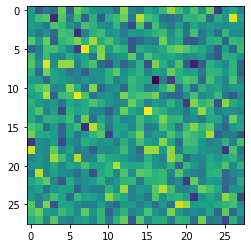

In [ ]:
from torch import nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F
from torchvision import models
from torchsummary import summary

import random

# prints a random start epoch
t = random.choice([5,6,7,8,9,10,11,12]) #using name t in accordance with the paper

# load and train netwrok on synthetic dataset
s_net = utils.get_network(args.model,channel=channel,num_classes=num_classes,im_size=im_size).to(args.device)
s_net.fc_1.weight=copy.deepcopy(expert_trajectory[t][0])
s_net.fc_2.weight=copy.deepcopy(expert_trajectory[t][1])
s_net.fc_3.weight=copy.deepcopy(expert_trajectory[t][2])


accurracy = []
it_eval = 1
_, train_acc, test_acc = utils.evaluate_synset(it_eval, s_net, images_syn, labels_syn, testloader, args)
accurracy.append(test_acc)

#print(labels_syn)
#plt.imshow(images_syn[1][0].cpu().detach().numpy())
#print("sum img",sum(sum(images_syn[1][0])))





In [ ]:
#theta t+N
#pred=s_net.modules
#layer_names = dict(s_net.named_modules())

#theta t
print("t=",t)
start=expert_trajectory[t]

#theta t+M
stop=expert_trajectory[t+15]
#print(sum(sum(stop[0])))


#compute loss
change=[] #change of trajectory in teacher model
change.append(start[0]-stop[0])
change.append(start[1]-stop[1])
change.append(start[2]-stop[2])
diff=[] #difference with target trajectory
diff.append(s_net.fc_1.weight-stop[0])
diff.append(s_net.fc_2.weight-stop[1])
diff.append(s_net.fc_3.weight-stop[2])

numerator=(sum(sum(diff[0]**2))+sum(sum(diff[1]**2))+sum(sum(diff[2]**2)))
denominator=(sum(sum(change[0]**2))+sum(sum(change[1]**2))+sum(sum(change[2]**2)))
Loss = numerator/denominator
print("num=",numerator, "\nden=",denominator,"\nloss=", Loss)



print("start  ",sum(sum(start[0])))
print("student",sum(sum(s_net.fc_1.weight)))
print("stop   ",sum(sum(stop[0])))

print("start  ",sum(sum(start[1])))
print("student",sum(sum(s_net.fc_2.weight)))
print("stop   ",sum(sum(stop[1])))

print("start  ",sum(sum(start[2])))
print("student",sum(sum(s_net.fc_3.weight)))
print("stop   ",sum(sum(stop[2])))


t= 9
num= tensor(5.4209, device='cuda:0', grad_fn=<AddBackward0>) 
den= tensor(4.6990, device='cuda:0', grad_fn=<AddBackward0>) 
loss= tensor(1.1536, device='cuda:0', grad_fn=<DivBackward0>)
start   tensor(-120.2537, device='cuda:0', grad_fn=<AddBackward0>)
student tensor(-119.6215, device='cuda:0', grad_fn=<AddBackward0>)
stop    tensor(-117.3701, device='cuda:0', grad_fn=<AddBackward0>)
start   tensor(70.0052, device='cuda:0', grad_fn=<AddBackward0>)
student tensor(65.6870, device='cuda:0', grad_fn=<AddBackward0>)
stop    tensor(86.3595, device='cuda:0', grad_fn=<AddBackward0>)
start   tensor(0.1373, device='cuda:0', grad_fn=<AddBackward0>)
student tensor(0.1373, device='cuda:0', grad_fn=<AddBackward0>)
stop    tensor(0.1250, device='cuda:0', grad_fn=<AddBackward0>)


tensor(-16.4419, device='cuda:0', grad_fn=<AddBackward0>)
sum img tensor(-16.4419, device='cuda:0', grad_fn=<AddBackward0>)


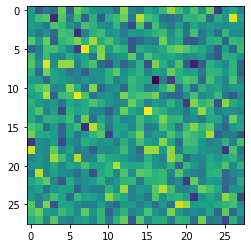

In [ ]:
s_net.requires_grad=False
optimizer = torch.optim.SGD(      [images_syn, ],       lr=args.lr_img,       momentum=0.5) 
criterion = nn.MSELoss().to(args.device)

loss = criterion((stop[0]),(s_net.fc_1.weight))
loss.backward()
optimizer.step()
optimizer.zero_grad()

plt.imshow(images_syn[1][0].cpu().detach().numpy())
print("sum img",sum(sum(images_syn[1][0])))

loss = criterion((stop[0]),(s_net.fc_1.weight))
loss.backward()
optimizer.step()
optimizer.zero_grad()

plt.imshow(images_syn[1][0].cpu().detach().numpy())
print("sum img",sum(sum(images_syn[1][0])))

loss = criterion((stop[0]),(s_net.fc_1.weight))
loss.backward()
optimizer.step()
optimizer.zero_grad()

plt.imshow(images_syn[1][0].cpu().detach().numpy())
print("sum img",sum(sum(images_syn[1][0])))